In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

# Load the DistilGPT-2 model and tokenizer
model = GPT2LMHeadModel.from_pretrained('distilgpt2')
tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2')

# Make sure to set the model to evaluation mode
model.eval()

def llm_predict_paddle_action(ball_x, ball_y, player_paddle_y):
    # Construct the game state description
    input_text = (f"The ball is at position ({ball_x}, {ball_y}). "
                  f"The paddle is at y = {player_paddle_y}. "
                  f"Should the paddle move up, down, or stay still to intercept the ball?")

    # Tokenize the input text
    inputs = tokenizer(input_text, return_tensors="pt")

    # Generate the model's output
    with torch.no_grad():
        outputs = model.generate(inputs['input_ids'], max_new_tokens=10)

    # Decode the output and extract the generated text
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"Model output: {generated_text}")

    # Infer the paddle movement from the generated text
    if 'up' in generated_text:
        return 2  # Move up
    elif 'down' in generated_text:
        return 3  # Move down
    else:
        return 0  # Stay still


In [ ]:
import time
import gym
import cv2
import numpy as np

# Initialize the Pong environment
env = gym.make('Pong-v4', render_mode='rgb_array')
env.reset()
def detect_ball(frame):
    if frame is not None:
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        _, thresh_frame = cv2.threshold(gray_frame, 150, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh_frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if w < 15 and h < 15:
                return (x, y)
    return None


In [ ]:
import time
import gym
import cv2
import numpy as np
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from google.colab.patches import cv2_imshow

# Initialize the LLM (DistilGPT-2 model)
model = GPT2LMHeadModel.from_pretrained('distilgpt2')
tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2')

# Set the pad_token to eos_token
tokenizer.pad_token = tokenizer.eos_token

# Set model to evaluation mode
model.eval()

# Initialize the Pong environment
env = gym.make('Pong-v4', render_mode='rgb_array')
env.reset()

def detect_ball(frame):
    if frame is not None:
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        _, thresh_frame = cv2.threshold(gray_frame, 150, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh_frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if w < 15 and h < 15:
                return (x, y)
    return None

# Function to make the paddle move faster and more precisely towards the ball
def get_paddle_action(predicted_ball_y, player_paddle_y):
    movement_speed = 10  # Adjust this to make the paddle move faster
    threshold = 5  # Threshold to determine when the paddle is close enough to the ball

    # If the ball is already within a small range, stop moving
    if abs(predicted_ball_y - player_paddle_y) <= threshold:
        return 0  # Stay still

    # If the ball is below the paddle, move down
    if predicted_ball_y > player_paddle_y:
        if abs(predicted_ball_y - player_paddle_y) > movement_speed:
            return 3  # Move down faster
        else:
            return 0  # Stay still if already close

    # If the ball is above the paddle, move up
    elif predicted_ball_y < player_paddle_y:
        if abs(predicted_ball_y - player_paddle_y) > movement_speed:
            return 2  # Move up faster
        else:
            return 0  # Stay still if already close

# Function to predict the future position of the ball
def predict_ball_y(ball_x, ball_y, prev_ball_x, prev_ball_y, paddle_x):
    # Calculate the ball's velocity in x and y directions
    ball_velocity_x = ball_x - prev_ball_x
    ball_velocity_y = ball_y - prev_ball_y

    if ball_velocity_x == 0:
        # Ball is not moving in x direction, no prediction possible
        return ball_y

    # Time to reach the paddle
    time_to_reach_paddle = (paddle_x - ball_x) / ball_velocity_x

    # Predict future y position of the ball
    predicted_ball_y = ball_y + ball_velocity_y * time_to_reach_paddle

    # Handle bouncing off the top and bottom of the screen
    while predicted_ball_y < 0 or predicted_ball_y > 210:
        if predicted_ball_y < 0:
            predicted_ball_y = -predicted_ball_y
        elif predicted_ball_y > 210:
            predicted_ball_y = 420 - predicted_ball_y

    return predicted_ball_y

# Function to use LLM to predict paddle movement based on ball position and velocity
def llm_predict_paddle_action(ball_y, paddle_y):
    input_text = (f"The ball is at y = {ball_y}, and the paddle is at y = {paddle_y}. "
                  "Should the paddle move up or down?")

    # Tokenize the input text
    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True)

    # Generate the model's output
    with torch.no_grad():
        outputs = model.generate(
            inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            max_new_tokens=10,
            pad_token_id=tokenizer.eos_token_id
        )

    # Decode the output and extract the generated text
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"Model output: {generated_text}")

    # Post-process the output to detect movement keywords
    if 'up' in generated_text.lower():
        return 2  # Move up
    elif 'down' in generated_text.lower():
        return 3  # Move down
    else:
        return 0  # Stay still (fallback case, though ideally this option should be removed)

        # Main game loop with LLM-based decision logic and rule-based overrides
def random_play():
    step = 0
    score = 0
    player_paddle_y = 80  # Initial paddle y position
    prev_ball_x, prev_ball_y = None, None  # Previous ball position
    contact_made = False  # Track if the paddle makes contact with the ball

    env.reset()
    # env.seed(2)
    env.seed(20)

    while True:
        step += 1

        # Render the game
        time.sleep(0.05)  # Adjust the delay for smoother gameplay
        frame = env.render(mode='rgb_array')

        if frame is not None:
            print(f"Frame captured successfully: {frame.shape}")
        else:
            print("Failed to capture frame.")
            continue

        # Detect the ball's position
        ball_position = detect_ball(frame)
        if ball_position:
            ball_x, ball_y = ball_position
            print(f"Ball position: {ball_position}")

            # If we have a previous ball position, calculate its velocity and predict future position
            if prev_ball_x is not None and prev_ball_y is not None:
                paddle_x = 144  # X-coordinate of the paddle
                predicted_ball_y = predict_ball_y(ball_x, ball_y, prev_ball_x, prev_ball_y, paddle_x)
                print(f"Predicted ball y position: {predicted_ball_y}")

                # Use rule-based logic to move the paddle based on ball's predicted position
                action = get_paddle_action(predicted_ball_y, player_paddle_y)
            else:
                action = 0  # Stay still if we don't have enough info about ball movement

            # Update previous ball position
            prev_ball_x, prev_ball_y = ball_x, ball_y
        else:
            print("Ball not found, staying still.")
            action = 0  # Stay still if ball not found

        # Perform the action in the environment
        state, reward, done, info = env.step(action)

        # Apply custom rewards
        if reward != 0:
            if reward > 0 and not contact_made:
                reward += 10  # Increase reward for contact with the ball
                contact_made = True  # Mark contact made
                print("Contact with the ball! Increased reward.")

            if reward > 0 and contact_made:
                reward += 1  # Increase reward for scoring
                print("Point scored! Greatly increased reward.")

            score += reward
            print(f"Score updated: {score}")

        # Update player paddle Y position based on action
        if action == 2:  # Moving up
            player_paddle_y = max(0, player_paddle_y - 20)  # Faster movement
        elif action == 3:  # Moving down
            player_paddle_y = min(210, player_paddle_y + 20)

        # Add text to display the action selected
        action_text = "Action: Stay" if action == 0 else ("Action: Move Up" if action == 2 else "Action: Move Down")
        cv2.putText(frame, action_text, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        # Add text to display the score
        score_text = f"Score: {score}"
        cv2.putText(frame, score_text, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        # Display the frame with action and score overlay
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # Convert to BGR for OpenCV
        cv2_imshow(frame_bgr)  # Use the Colab-specific function to display the frame

        # If the game is done, end the loop
        if done or step > 500:
            env.close()
            print("Your Score at the end of the game is: ", score)
            break
random_play()

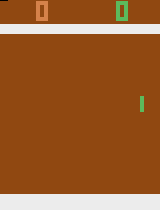

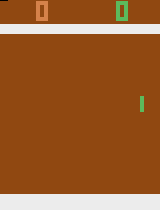

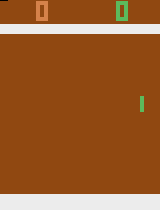

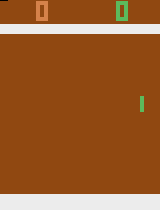

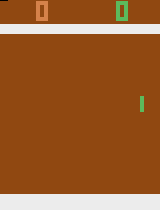

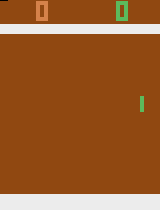

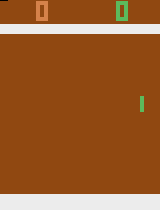

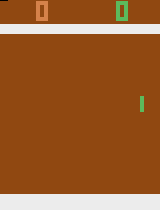

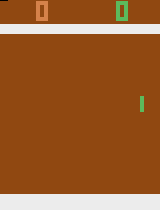

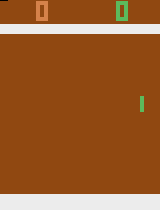

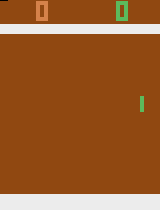

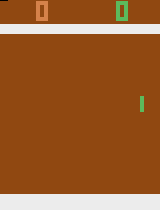

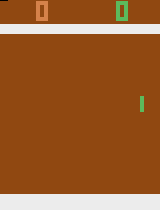

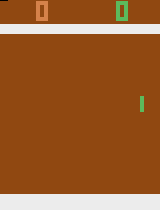

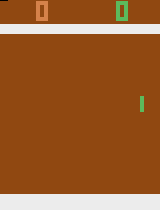

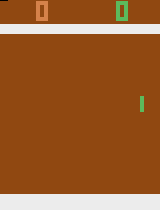

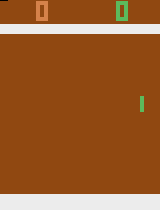

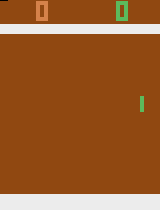

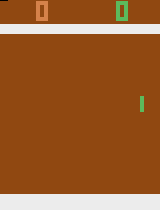

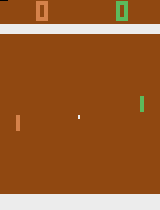

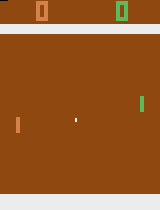

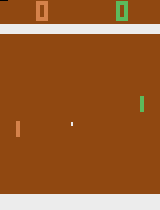

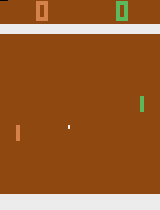

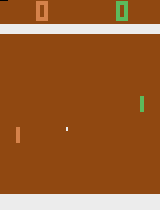

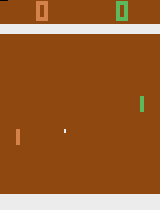

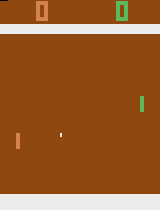

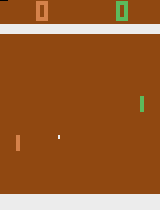

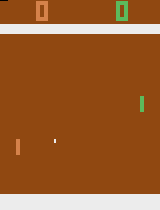

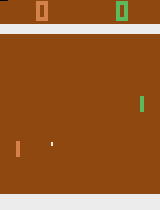

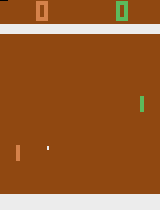

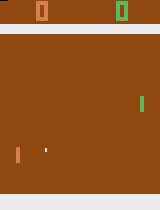

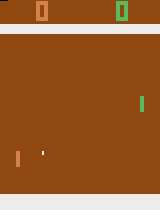

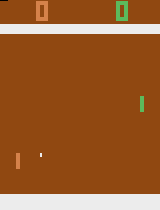

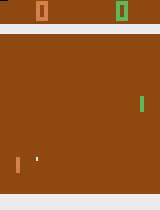

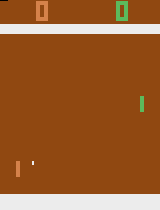

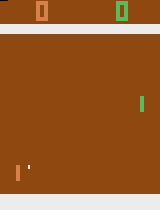

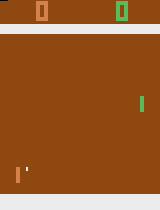

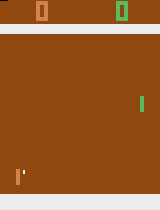

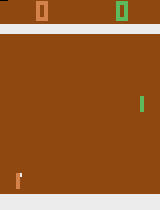

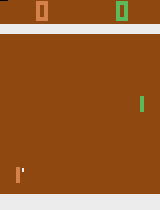

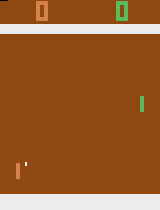

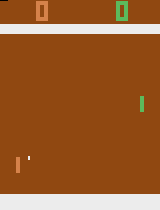

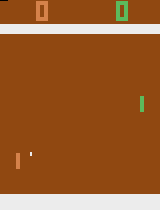

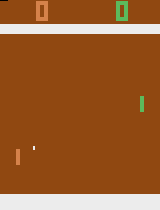

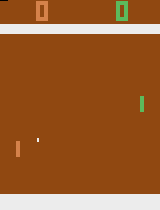

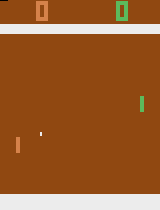

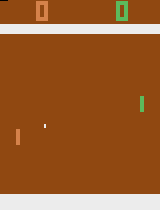

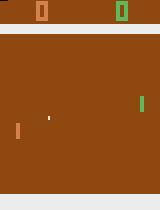

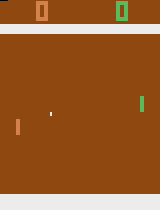

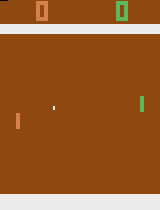

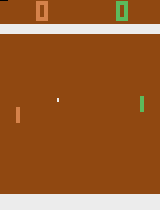

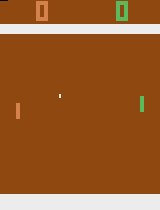

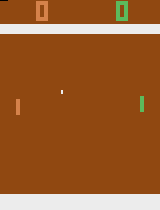

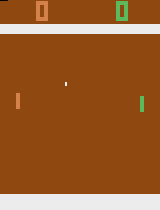

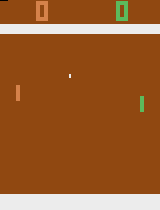

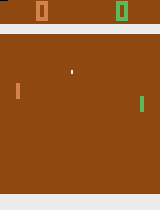

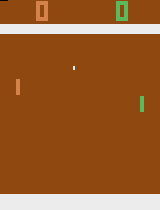

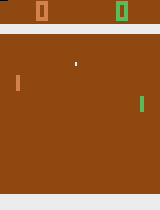

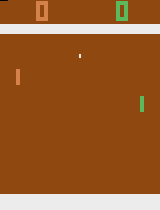

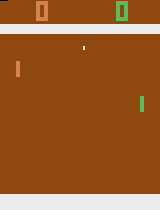

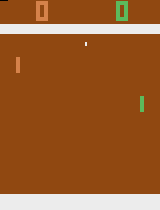

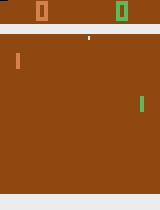

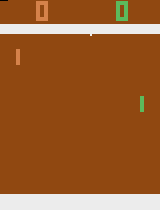

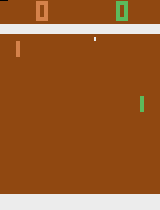

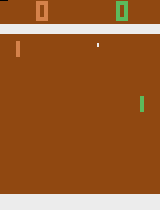

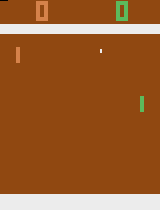

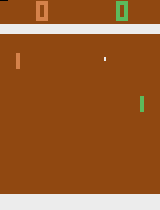

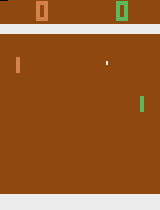

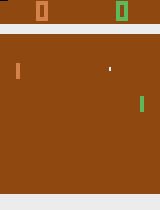

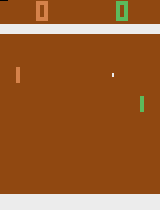

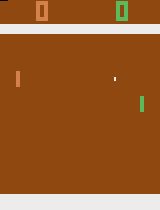

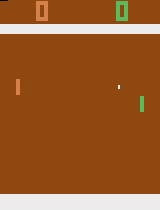

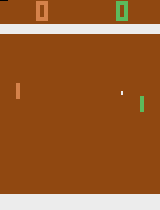

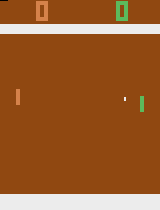

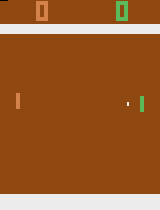

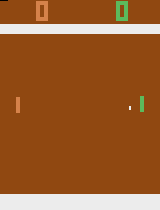

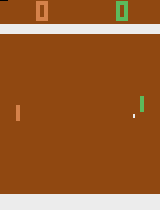

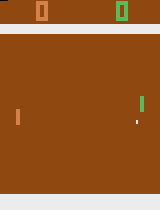

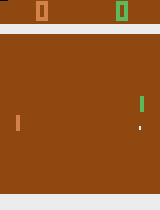

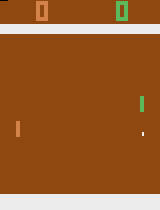

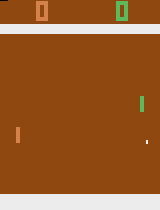

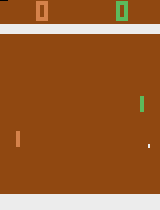

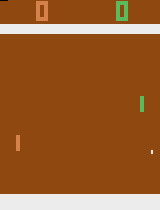

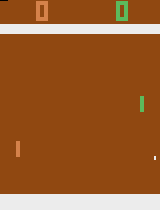

Score updated: -1.0


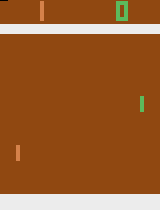

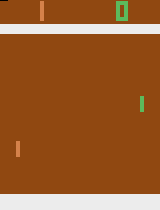

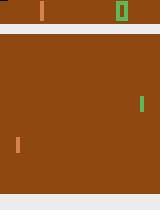

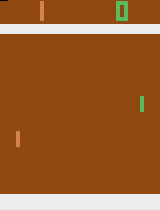

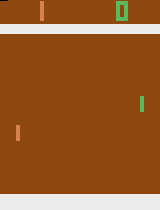

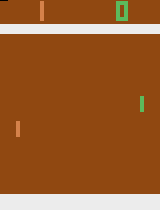

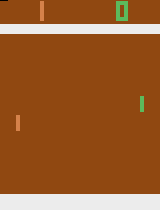

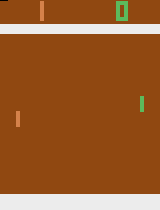

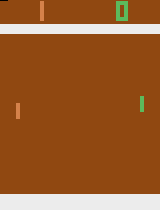

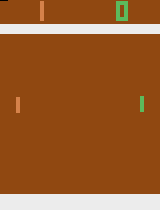

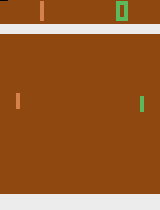

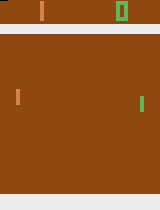

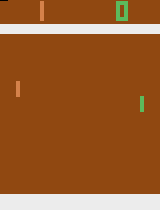

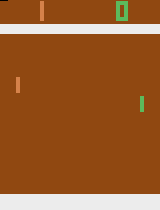

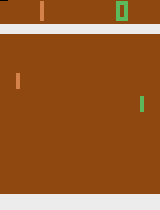

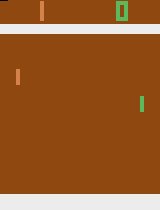

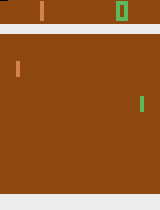

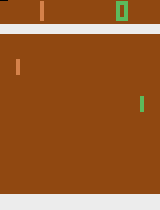

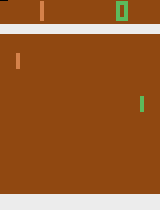

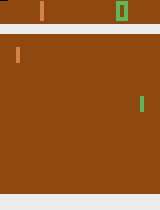

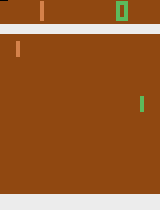

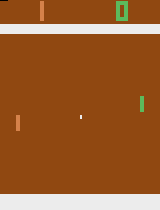

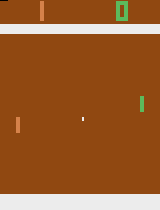

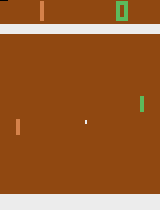

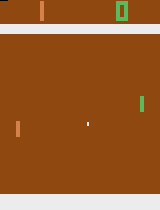

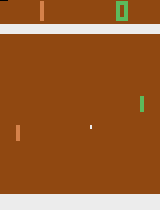

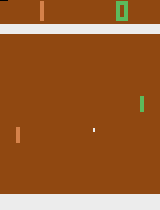

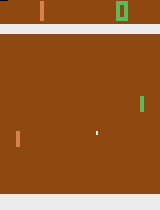

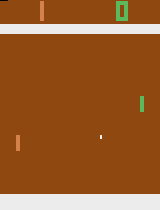

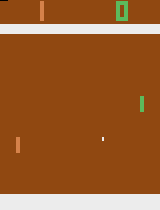

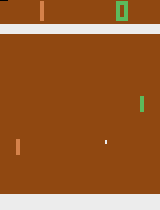

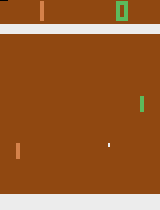

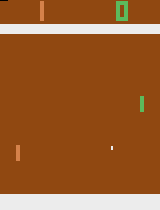

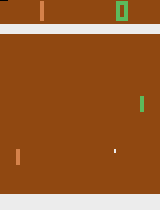

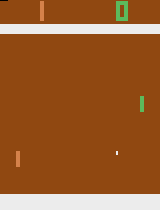

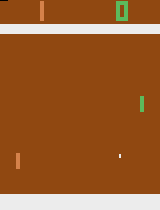

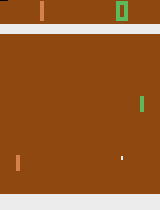

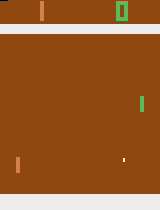

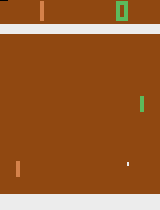

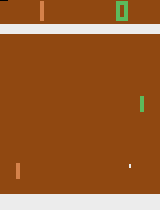

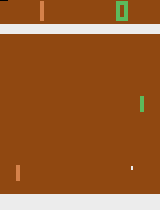

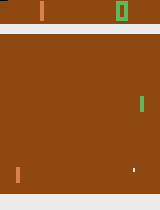

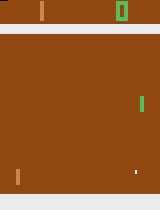

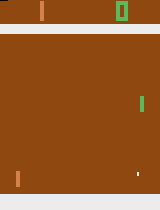

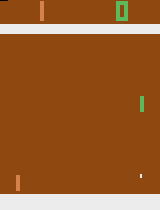

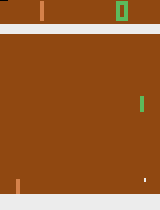

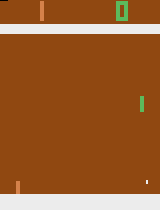

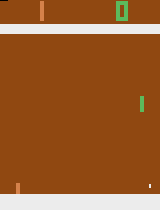

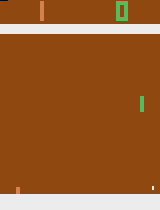

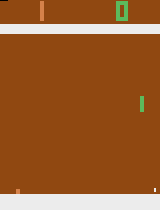

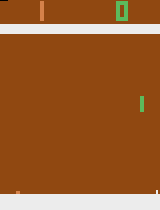

Score updated: -2.0


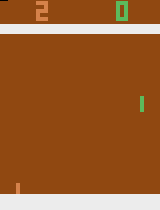

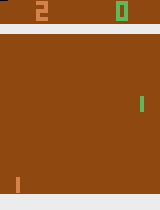

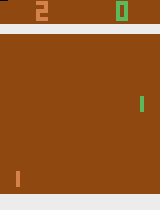

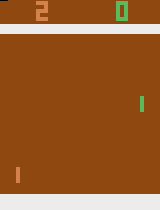

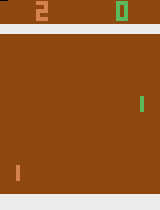

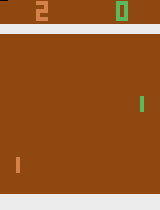

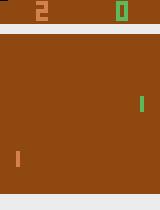

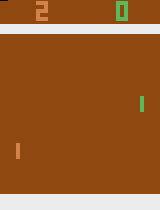

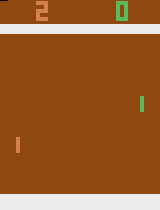

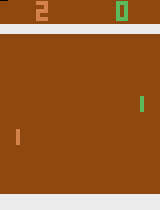

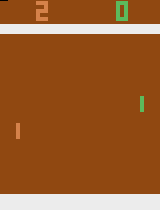

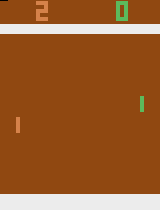

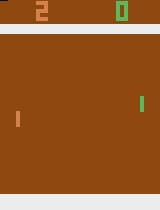

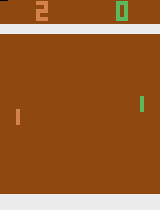

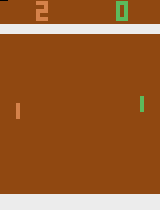

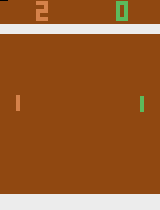

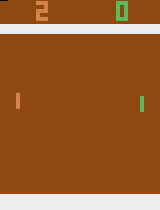

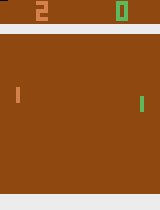

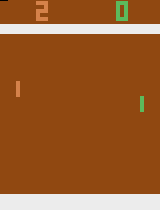

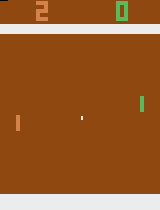

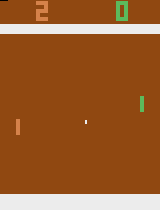

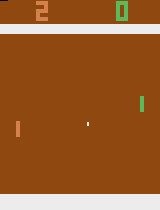

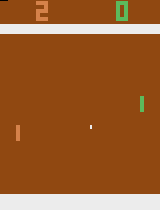

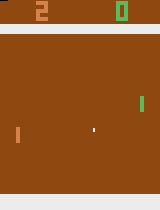

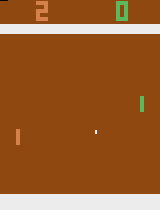

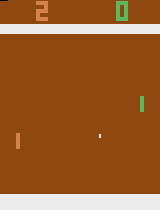

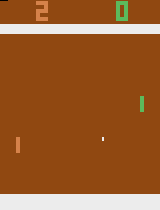

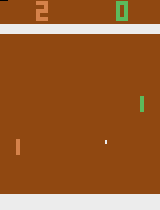

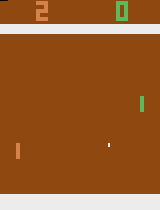

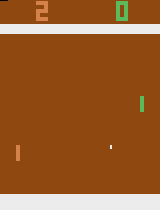

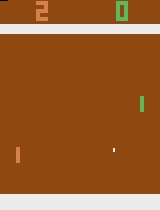

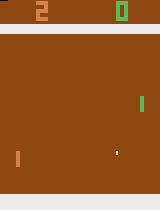

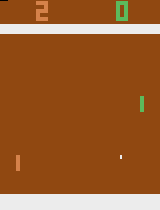

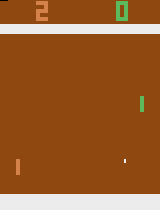

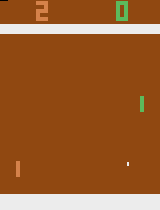

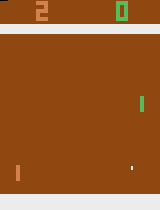

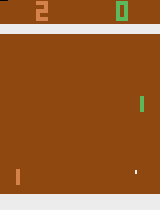

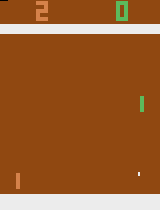

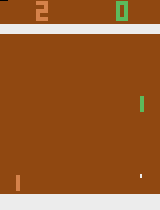

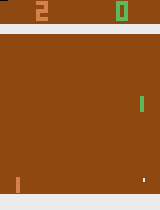

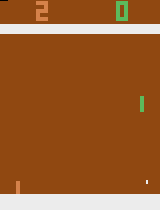

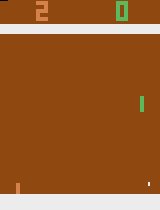

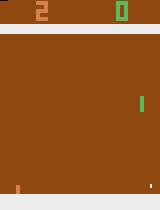

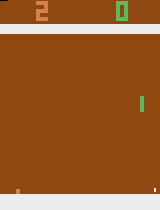

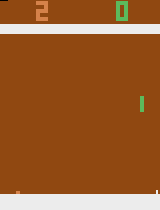

Score updated: -3.0


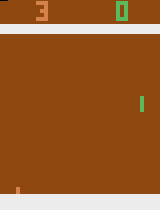

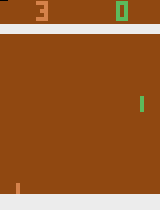

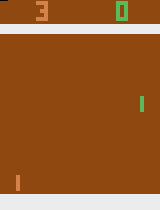

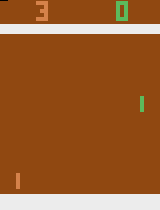

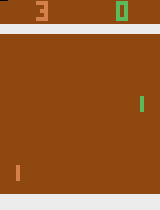

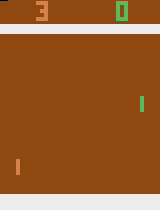

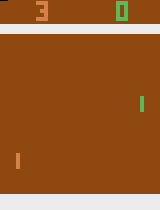

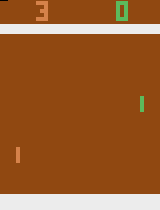

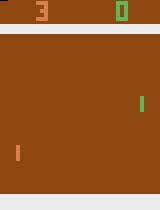

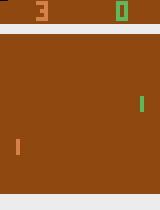

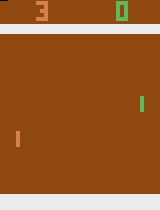

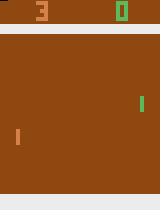

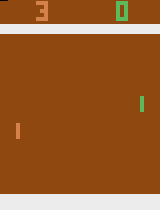

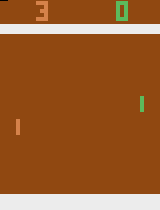

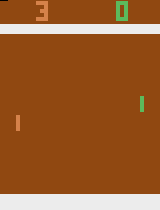

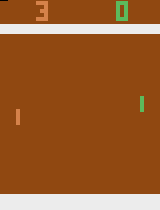

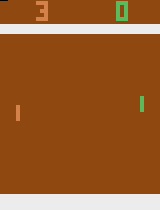

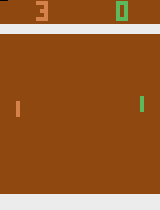

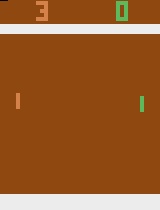

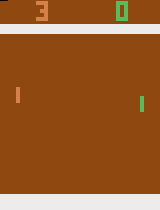

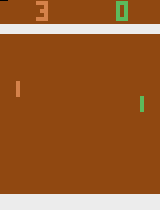

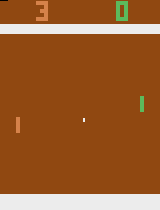

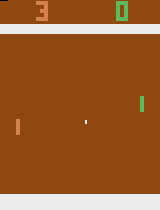

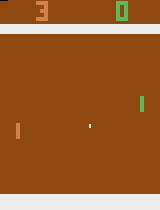

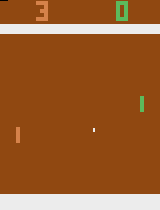

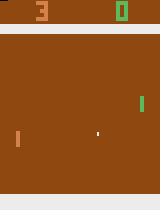

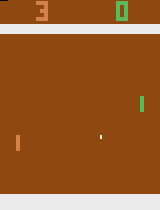

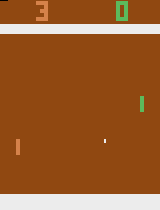

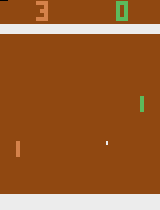

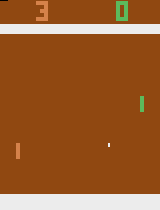

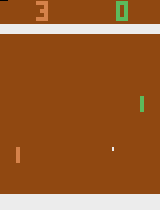

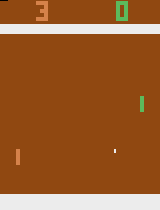

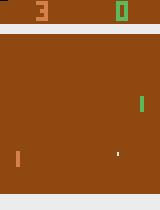

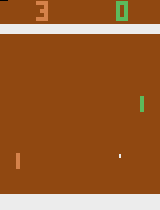

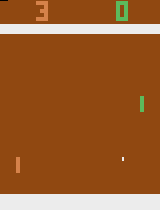

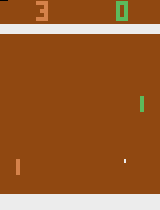

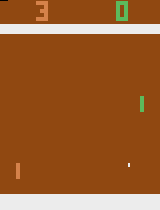

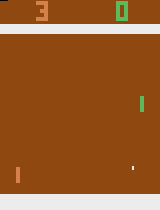

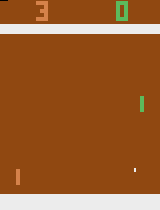

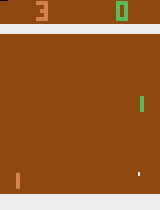

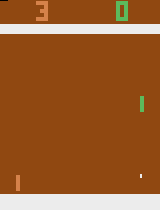

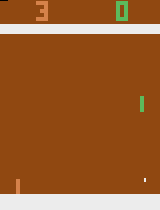

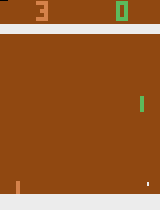

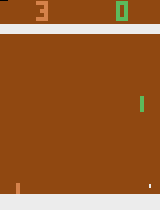

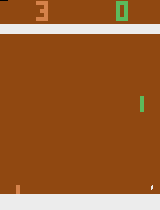

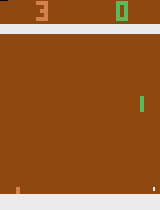

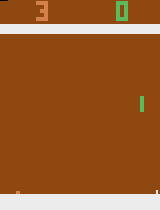

Score updated: -4.0


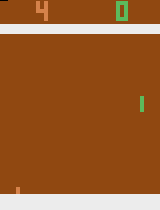

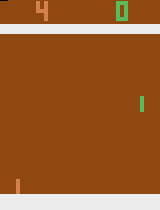

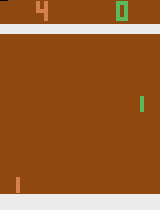

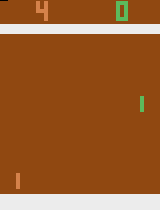

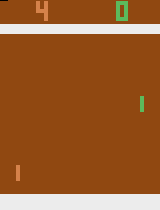

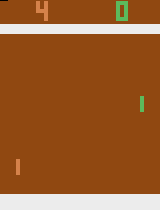

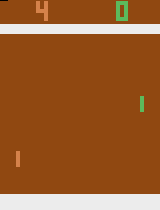

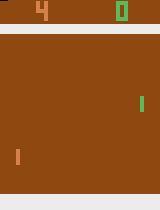

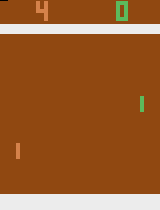

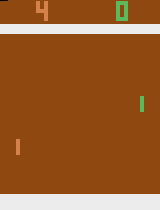

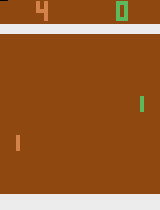

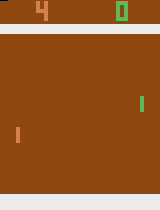

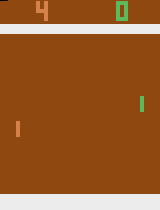

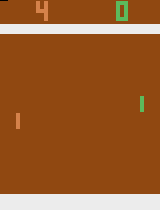

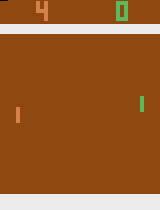

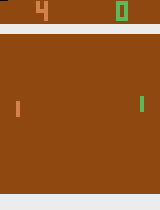

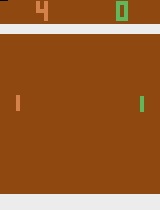

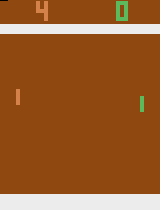

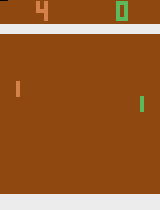

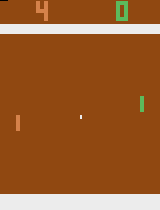

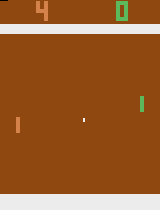

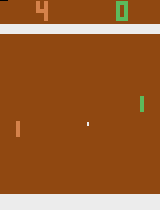

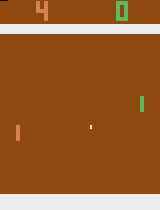

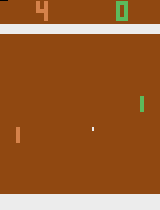

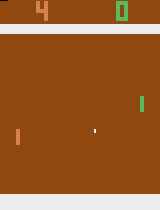

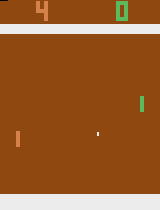

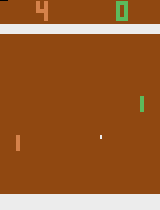

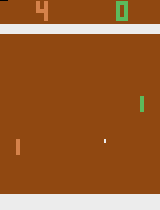

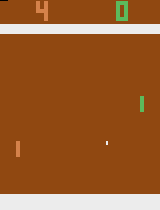

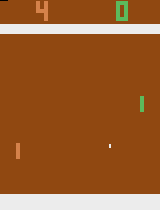

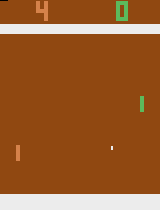

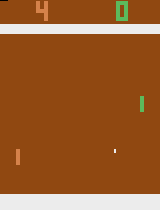

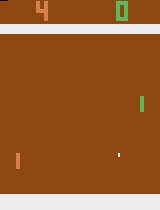

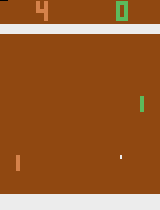

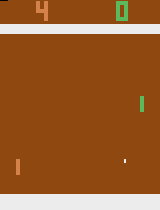

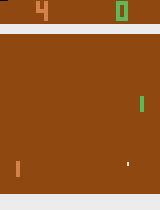

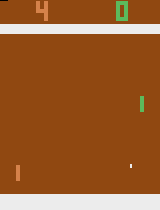

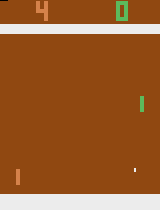

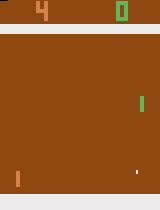

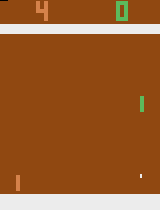

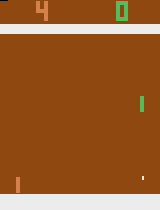

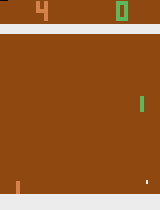

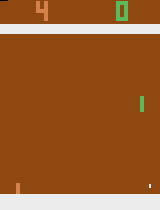

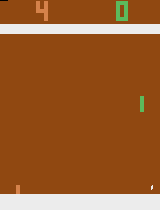

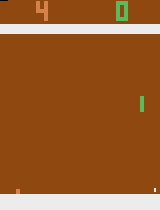

Score updated: -5.0


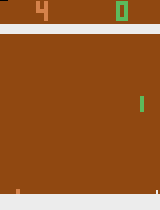

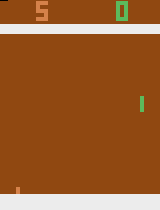

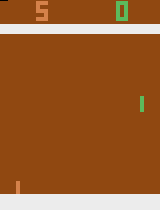

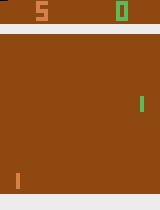

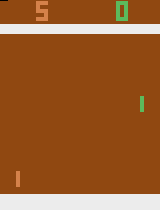

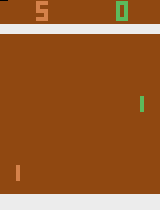

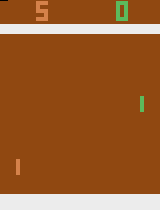

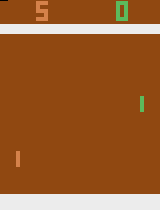

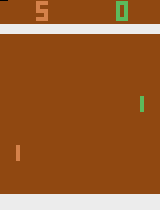

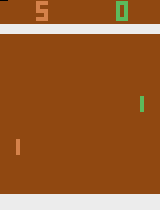

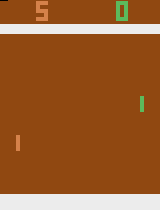

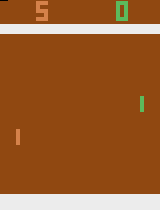

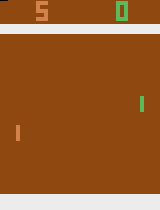

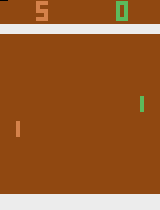

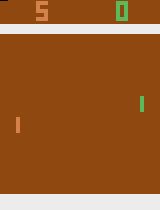

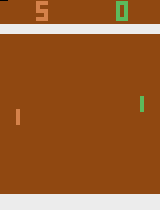

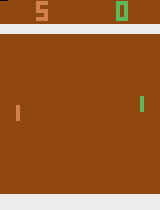

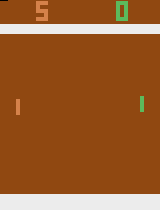

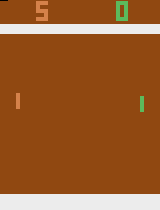

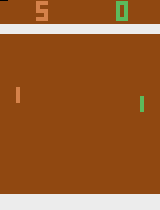

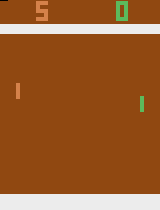

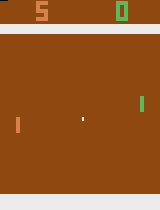

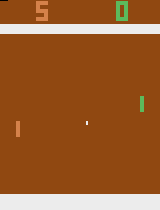

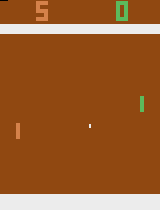

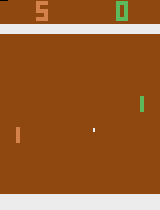

KeyboardInterrupt: 

In [19]:
import time
import gym
import cv2
import numpy as np
import pygame
from google.colab.patches import cv2_imshow  # Import the Colab-specific imshow function

# Initialize the Pong environment in 'rgb_array' mode
env = gym.make('Pong-v4', render_mode='rgb_array')
env.reset()

# Initialize pygame to capture keyboard inputs
pygame.init()
screen = pygame.display.set_mode((400, 300))

def human_play():
    step = 0
    score = 0
    player_paddle_y = 80  # Initial paddle y position

    env.reset()

    running = True
    while running:
        step += 1

        # Handle events for quitting the game or pressing keys
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        # Capture key presses
        keys = pygame.key.get_pressed()

        # Move the paddle up if the up arrow is pressed
        if keys[pygame.K_UP]:
            action = 2  # Move up
        # Move the paddle down if the down arrow is pressed
        elif keys[pygame.K_DOWN]:
            action = 3  # Move down
        else:
            action = 0  # Stay still

        # Perform the action in the environment
        state, reward, done, info = env.step(action)

        # Update player paddle Y position based on action
        if action == 2:  # Moving up
            player_paddle_y = max(0, player_paddle_y - 20)  # Faster movement
        elif action == 3:  # Moving down
            player_paddle_y = min(210, player_paddle_y + 20)

        # Update score based on reward
        if reward != 0:
            score += reward
            print(f"Score updated: {score}")

        # Render the game as rgb_array and display it with OpenCV
        frame = env.render(mode='rgb_array')  # Corrected render call
        if frame is not None:
            frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # Convert to BGR for OpenCV
            cv2_imshow(frame_bgr)  # Use the Colab-specific function to display the frame

        # Check if the user presses the ESC key to quit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            running = False

        # If the game is done, end the loop
        if done:
            env.close()
            print("Your Score at the end of the game is: ", score)
            break

        # Delay to make the game playable at human speed
        time.sleep(0.05)

    # Close OpenCV window
    cv2.destroyAllWindows()

# Run the human-controlled game loop
human_play()

# Quit pygame when the game is closed
pygame.quit()
